In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
coords_error = pd.read_csv('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/tmp/coords.csv')
imgs = np.load('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/tmp/imgs.npy')

In [3]:
print(list(coords_error))
print(imgs.shape)

['Unnamed: 0', 'x', 'y', 'error']
(24477, 32, 32, 1)


array([[<AxesSubplot:title={'center':'error'}>]], dtype=object)

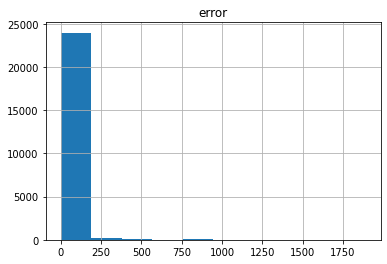

In [4]:
coords_error.hist('error')

In [5]:
coords_error['failure'] = coords_error['error'] > 70

In [6]:
good_images_idx = np.where(coords_error['failure'])[0]
bad_images_idx = np.where(~coords_error['failure'])[0]
good_images = imgs[good_images_idx]
bad_images = imgs[bad_images_idx]
print(good_images.shape)
print(bad_images.shape)

(7536, 32, 32, 1)
(16941, 32, 32, 1)


In [7]:
from final_project.smlm_3d.experiments.noise.signal_noise_ratio import estimate_nsr_ratio

In [8]:
coords_error['nsr'] = list(map(estimate_nsr_ratio, imgs))

<AxesSubplot:title={'center':'nsr'}, xlabel='failure'>

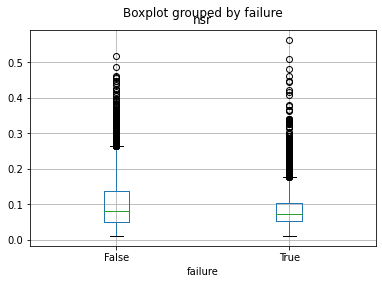

In [9]:
coords_error.boxplot('nsr', by='failure')


In [10]:
all_images = np.concatenate((good_images, bad_images))
labels = np.concatenate((np.ones((good_images.shape[0])), np.zeros((bad_images.shape[0]))))

In [11]:
# import torchvision
# from torch import nn
# import torch
# import torch.optim as optim
# from sklearn.model_selection import train_test_split
# from torch.utils.data import Dataset
# from pytorch_lightning.core.lightning import LightningModule
# from torch.nn import functional as F
# from pytorch_lightning import Trainer
# from torch.optim import Adam

# SEED = 42
# BATCH_SIZE=1000

# all_images = np.concatenate((good_images, bad_images))
# labels = np.concatenate((np.ones((good_images.shape[0])), np.zeros((bad_images.shape[0])))).astype(float)

# all_images = np.moveaxis(all_images, 3, 1)

# all_images = all_images.astype(np.float32)
# labels = labels.astype(np.float32)
# train_x, val_x, train_y, val_y = train_test_split(all_images, labels, test_size=0.3, stratify=labels, shuffle=True, random_state=SEED) 

# print(train_x.shape)
# print(val_x.shape)
# print(train_y.shape)
# print(val_y.shape)


# class CustomImageDataset(Dataset):
#     def __init__(self, imgs, labels):
#         self.imgs = imgs
#         self.labels = labels

#     def __len__(self):
#         return len(self.imgs)

#     def __getitem__(self, idx):
#         return self.imgs[idx], self.labels[idx]
        
# train_dataset = CustomImageDataset(train_x, train_y)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
#                                           shuffle=True, num_workers=2)

# val_dataset = CustomImageDataset(val_x, val_y)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
#                                           shuffle=True, num_workers=2)

# def create_model(num_classes):
#     model = torchvision.models.resnet18(pretrained=False, num_classes=num_classes)
#     model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#     model.maxpool = nn.Identity()
#     return model

# class LitModule(LightningModule):
#     def __init__(self):
#         super().__init__()
#         self.model = create_model(2)
    
#     def forward(self, x):
#         x = self.model(x)
#         return F.log_softmax(x, dim=1)
    
#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         logits = self(x)
#         print((logits.dtype))
#         print(y.dtype)
#         loss = F.nll_loss(logits, y)
#         return loss
#     def configure_optimizers(self):
#         return Adam(self.parameters(), lr=1e-3)

# trainer = Trainer()
# model = LitModule()

# model = model.float()


# trainer.fit(model, train_loader)


# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

In [12]:
import torch
from torch import nn
import torchvision
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.nn import functional as F
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef
from torch.utils.data import Dataset

SEED = 42
BATCH_SIZE=1000

def create_model(num_classes):
    model = torchvision.models.resnet18(pretrained=False, num_classes=num_classes)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model

class FullDataset(Dataset):
    """Basic class encapulating dataset functions, for use with dataloader."""

    def __init__(self, img_numpy_array: np.ndarray, labels_numpy_array: np.ndarray) -> None:
        """Initialise with numpy array."""
        self.img_data = img_numpy_array
        self.labels = torch.from_numpy(labels_numpy_array)
        print("Array shape loaded into torch dataset:", self.img_data.shape)

    def __len__(self) -> int:
        """Return length of dataset."""
        assert self.img_data.shape[0] == self.labels.shape[0]
        return self.img_data.shape[0]

    def __getitem__(self, idx) -> torch.Tensor:
        """Return items from dataset as torch tensors."""
        img_data_selection = self.img_data[idx]
        img_tensor = torch.from_numpy(img_data_selection).float()
        return (img_tensor, self.labels[idx])


class LitResnet(LightningModule):
    def __init__(self, lr=0.05, train_dataset_len=640, num_classes=2):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model(num_classes)
        
        self.train_dataset_len = train_dataset_len

    def forward(self, x):
        out = self.model(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).float()

        loss = F.binary_cross_entropy_with_logits(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.argmax(logits, dim=1)
        y = torch.argmax(y, dim=1)
        micro_acc = accuracy(preds, y, average="micro")
        macro_acc = accuracy(preds, y, average="macro", num_classes=2)

        return {
            "loss": loss.cpu(), 
            "micro_acc": micro_acc.cpu(),
            "macro_acc": macro_acc.cpu(),
            "preds": preds.cpu(),
            "labels": y.cpu()
        }
    
    def evaluation_epoch_end(self, outputs, stage=None):
        micro_acc = torch.stack([tmp[f"micro_acc"] for tmp in outputs]).mean()
        macro_acc = torch.stack([tmp[f"macro_acc"] for tmp in outputs]).mean()
        loss = torch.stack([tmp[f"loss"] for tmp in outputs]).mean()
        self.log_dict({f"{stage}_micro_acc": micro_acc, f"{stage}_macro_acc": macro_acc, f"{stage}_loss": loss}, logger=True, prog_bar=True)
        
        # preds = torch.cat([tmp[f"preds"] for tmp in outputs])
        # labels = torch.cat([tmp[f"labels"] for tmp in outputs])
        
        # conf_mat = confusion_matrix(preds, labels, num_classes=NUM_CLASSES)
        
        # np.save("/camp/project/proj-data-challenge/2021/Project1-El-Oakley/scripts/models/run-2/preds.npy", preds.detach().numpy())
        # np.save("/camp/project/proj-data-challenge/2021/Project1-El-Oakley/scripts/models/run-2/labels.npy", labels.detach().numpy())
        
        # np.save("/camp/project/proj-data-challenge/2021/Project1-El-Oakley/scripts/models/run-2/conf_mat.npy", conf_mat.numpy())
        
        

    def validation_step(self, batch, batch_idx):
        metrics = self.evaluate(batch, "val")
        return metrics
    
    def validation_epoch_end(self, outputs):
        self.evaluation_epoch_end(outputs, "val")

    def test_step(self, batch, batch_idx):
        metrics = self.evaluate(batch, "test")
        return metrics
    
    def test_epoch_end(self, outputs):
        self.evaluation_epoch_end(outputs, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
        )
        scheduler = MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.1)
        return [optimizer], [scheduler]

all_images = np.concatenate((good_images, bad_images))
all_images = np.moveaxis(all_images, 3, 1).astype(np.float32)

opp_labels = np.concatenate((np.zeros((good_images.shape[0])), np.ones((bad_images.shape[0]))))[:, np.newaxis]
labels = np.concatenate((np.ones((good_images.shape[0])), np.zeros((bad_images.shape[0]))))[:, np.newaxis]

labels = np.concatenate((labels, opp_labels), axis=1)
labels = labels.astype(np.float32)


train_x, val_x, train_y, val_y = train_test_split(all_images, labels, test_size=0.3, stratify=labels, shuffle=True, random_state=SEED) 

train_dataset = FullDataset(train_x, train_y)
val_dataset = FullDataset(val_x, val_y)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

early_stop_callback = EarlyStopping(monitor='val_macro_acc', patience=6, mode='max')

model_checkpoint = ModelCheckpoint(
    monitor='val_macro_acc',
    mode='max',
    filename='{epoch:02d}-{' + 'val_macro_acc' + ':.3f}',
    save_last=True,
    save_top_k=1,
    dirpath='/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/tmp/models/',
)
    
trainer = Trainer(
    progress_bar_refresh_rate=1,
    log_every_n_steps=1,
    max_epochs=30,
    gpus=-1,
    accelerator='dp',
    callbacks=[LearningRateMonitor(logging_interval="step"), early_stop_callback, model_checkpoint],
    checkpoint_callback=True,
    logger= TensorBoardLogger("tb_logs", name="my_model")
)

model = LitResnet()
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
    


/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/tmp/models/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Array shape loaded into torch dataset: (17133, 1, 32, 32)
Array shape loaded into torch dataset: (7344, 1, 32, 32)



  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.675    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [13]:
import shap
batch = next(iter(val_dataloader))
images, _ = batch
print(len(val_dataloader))
background = images[:100]
test_images = images[100:120]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

8


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


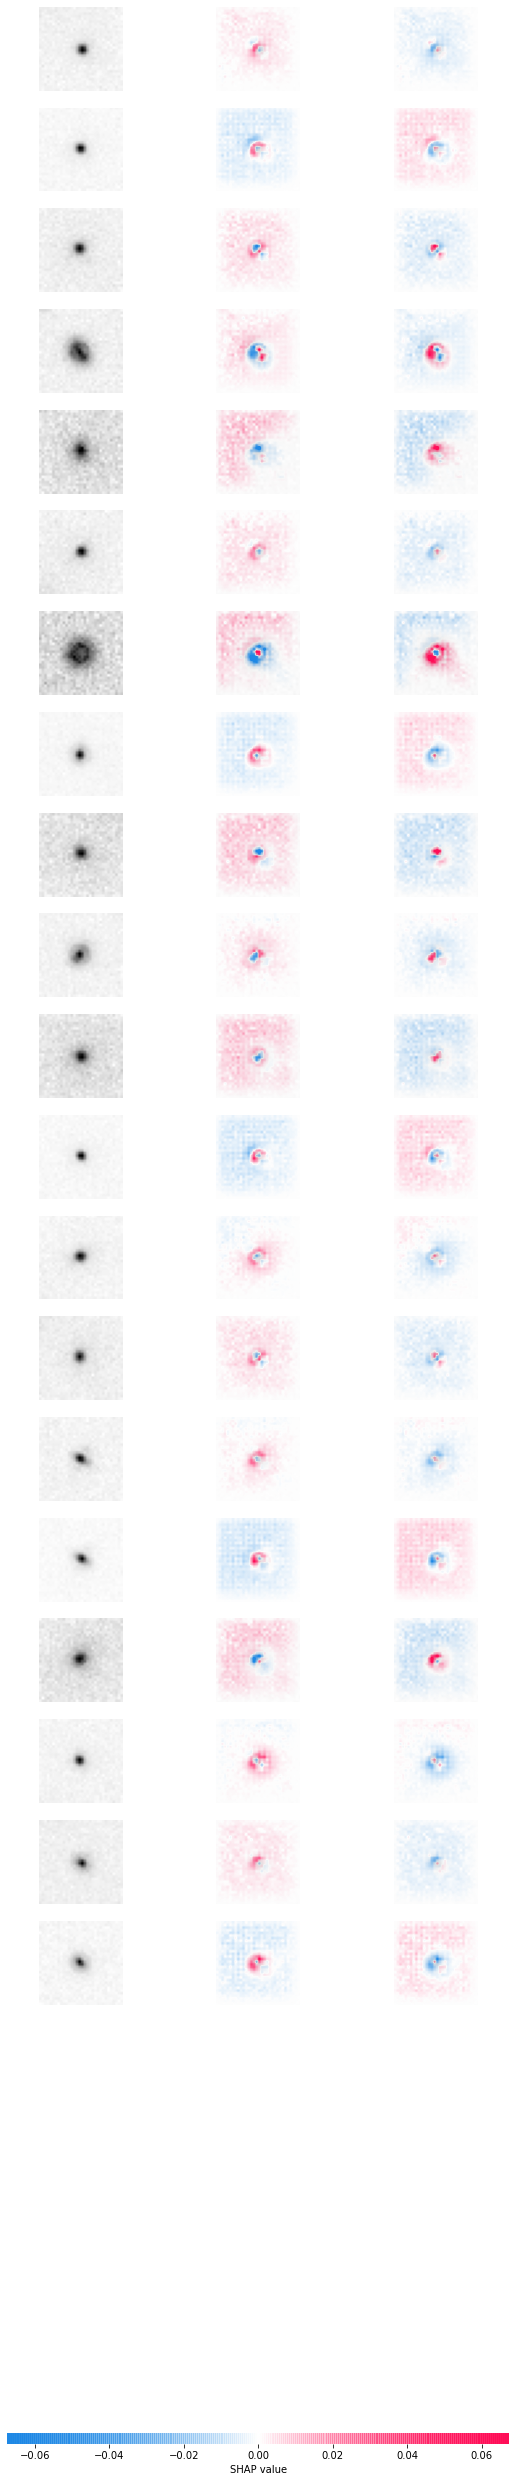

In [14]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)